In [1]:
from fcn8s_tensorflow import FCN8s
from data_generator.batch_generator import BatchGenerator
from helpers.visualization_utils import print_segmentation_onto_image
from cityscapesscripts.helpers.labels import TRAINIDS_TO_COLORS_DICT, TRAINIDS_TO_RGBA_DICT

from math import ceil
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [2]:
train_images = 'datasets/Cityscapes/leftImg8bit/train/'
val_images = 'datasets/Cityscapes/leftImg8bit/val/'
test_images = 'datasets/Cityscapes/leftImg8bit/test/'

train_gt = 'datasets/Cityscapes/gtFine/train/'
val_gt = 'datasets/Cityscapes/gtFine/val/'

train_image_dirs = [train_images]
train_ground_truth_dirs = [train_gt]
val_image_dirs = [val_images]
val_ground_truth_dirs = [val_gt]

num_classes = 20 

train_dataset = BatchGenerator(image_dirs=train_image_dirs,
                               image_file_extension='png',
                               ground_truth_dirs=train_ground_truth_dirs,
                               image_name_split_separator='leftImg8bit',
                               ground_truth_suffix='gtFine_labelIds',
                               check_existence=True,
                               num_classes=num_classes)

val_dataset = BatchGenerator(image_dirs=val_image_dirs,
                             image_file_extension='png',
                             ground_truth_dirs=val_ground_truth_dirs,
                             image_name_split_separator='leftImg8bit',
                             ground_truth_suffix='gtFine_labelIds',
                             check_existence=True,
                             num_classes=num_classes)

num_train_images = train_dataset.get_num_files()
num_val_images = val_dataset.get_num_files()

print("Size of training dataset: ", num_train_images, " images")
print("Size of validation dataset: ", num_val_images, " images")

Size of training dataset:  2975  images
Size of validation dataset:  500  images


In [3]:
batch_size = 4

train_generator = train_dataset.generate(batch_size=batch_size,
                                         convert_colors_to_ids=False,
                                         convert_ids_to_ids=False,
                                         convert_to_one_hot=True,
                                         void_class_id=None,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         brightness=False,
                                         flip=0.5,
                                         translate=False,
                                         scale=False,
                                         gray=False,
                                         to_disk=False,
                                         shuffle=True)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     convert_colors_to_ids=False,
                                     convert_ids_to_ids=False,
                                     convert_to_one_hot=True,
                                     void_class_id=None,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     gray=False,
                                     to_disk=False,
                                     shuffle=True)

In [5]:
start_time = time.time()
images, gt_images = next(train_generator)
print('Time to generate one batch: {:.3f} seconds'.format(time.time() - start_time))
print('Number of images generated:' , len(images))
print('Number of ground truth images generated:' , len(gt_images))

Time to generate one batch: 0.046 seconds
Number of images generated: 4
Number of ground truth images generated: 4


In [8]:
example_generator = train_dataset.generate(batch_size=batch_size,
                                           convert_to_one_hot=False)

In [64]:
example_images, example_gt_images = next(example_generator)

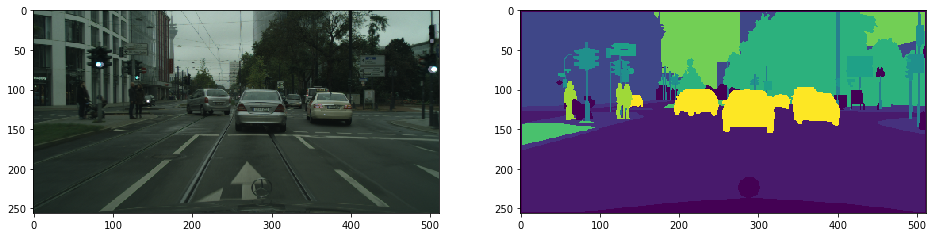

In [65]:
i = 0 

figure, cells = plt.subplots(1, 2, figsize=(16,8))
cells[0].imshow(example_images[i])
cells[1].imshow(example_gt_images[i])

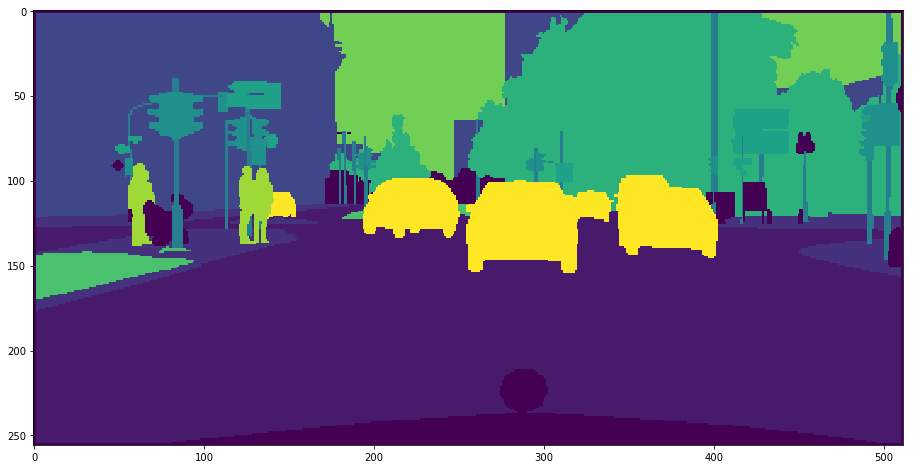

In [66]:
plt.figure(figsize=(16, 8))
plt.imshow(example_gt_images[i])

## Model

In [6]:
model = FCN8s(model_load_dir=None,
              tags=None,
              vgg16_dir='VGG-16_mod2FCN_ImageNet-Classification',
              num_classes=num_classes,
              variables_load_dir=None)

TensorFlow Version: 1.3.0
INFO:tensorflow:Restoring parameters from b'../../Google Drive/GitHub/Trained Models/VGG-16_mod2FCN_ImageNet-Classification/variables/variables'


In [7]:
epochs = 6 

def learning_rate_schedule(step):
    if step <= 10000: return 0.0001
    elif 10000 < step <= 20000: return 0.00001
    elif 20000 < step <= 40000: return 0.000003
    else: return 0.000001
    
model.train(train_generator=train_generator,
            epochs=epochs,
            steps_per_epoch=ceil(num_train_images/batch_size),
            learning_rate_schedule=learning_rate_schedule,
            keep_prob=0.5,
            l2_regularization=0.0,
            eval_dataset='val',
            eval_frequency=2,
            val_generator=val_generator,
            val_steps=ceil(num_val_images/batch_size),
            metrics={'loss', 'mean_iou', 'accuracy'},
            save_during_training=True,
            save_dir='cityscapes_model',
            save_best_only=True,
            save_tags=['default'],
            save_name='(batch-size-4)',
            save_frequency=2,
            saver='saved_model',
            monitor='loss',
            record_summaries=True,
            summaries_frequency=10,
            summaries_dir='tensorboard_log/cityscapes',
            summaries_name='configuration_01',
            training_loss_display_averaging=3)

Default GPU Device: /gpu:0
Evaluation on validation dataset: 100%|██████████| 125/125 [01:12<00:00,  1.74it/s]
loss: 0.8286  mean_iou: 0.2531  accuracy: 0.8111  
New best loss value, saving model.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'cityscapes_model/saved_model_(batch-size-4)_(globalstep-1488)_(trainloss-0.5900)_(eval_on_val_dataset)_(loss-0.8286)_(mean_iou-0.2531)_(accuracy-0.8111)/saved_model.pb'
Evaluation on validation dataset: 100%|██████████| 125/125 [01:11<00:00,  1.73it/s]
loss: 0.7130  mean_iou: 0.2894  accuracy: 0.8317  
New best loss value, saving model.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'cityscapes_model/saved_model_(batch-size-4)_(globalstep-2976)_(trainloss-0.7464)_(eval_on_val_dataset)_(loss-0.7130)_(mean_iou-0.2894)_(accuracy-0.8317)/saved_model.pb'
Evaluation on validation dataset: 100%|██████████| 125/125 [01:09<00:00

In [8]:
model.save(model_save_dir='cityscapes_model',
           saver='saved_model',
           tags=['default'],
           name='(batch-size-4)',
           include_global_step=True,
           include_last_training_loss=True,
           include_metrics=True,
           force_save=False)

Abort: Nothing to save, no training has been performed since the model was last saved.


## Evaluate

In [9]:
model.evaluate(data_generator=val_generator,
               metrics={'loss', 'mean_iou', 'accuracy'},
               num_batches=ceil(num_val_images/batch_size),
               l2_regularization=0.0,
               dataset='val')

Running evaluation: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]
loss: 0.6854  mean_iou: 0.3092  accuracy: 0.8392  


## Prediction

In [10]:
images, labels = next(val_generator)

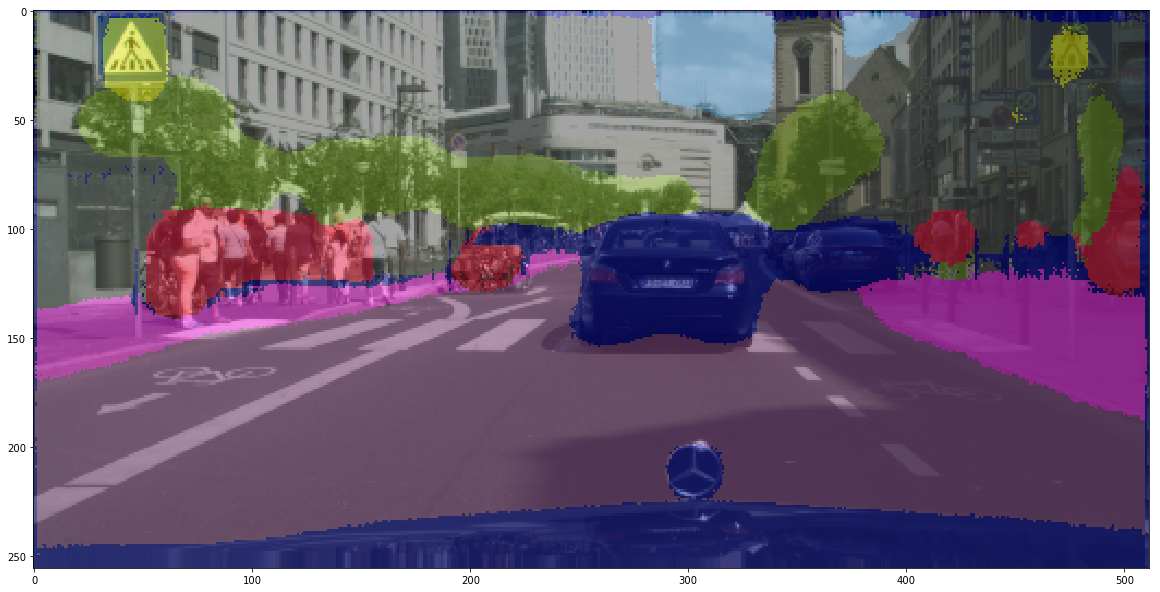

In [17]:
n = 3 

prediction = model.predict([images[n]], argmax=False)
segmented_image = print_segmentation_onto_image(images[n], prediction, color_map=TRAINIDS_TO_RGBA_DICT)

plt.figure(figsize=(20,14))
plt.imshow(segmented_image)